In [1]:
import tensorflow as tf
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import os
from skimage import data
from skimage import filters
from skimage import exposure

from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2

import pickle

import keras
from tensorflow.keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import Input 
from tensorflow.keras.optimizers import RMSprop
# Granulometry
from skimage import data
from skimage import filters
from skimage import exposure
#labelling
from skimage.morphology import label

In [2]:
class Granulometry:
    def __init__(self, minDisc=1, maxDisc=30, growth=1):
        self.sizes = range(minDisc, maxDisc, growth)
        nb = int((maxDisc - minDisc) / growth) 
        self.granulo = np.zeros(nb)
        
    def disk_structure(self, n):
        struct = np.zeros((2 * n + 1, 2 * n + 1))
        x, y = np.indices((2 * n + 1, 2 * n + 1))
        mask = (x - n)**2 + (y - n)**2 <= n**2
        struct[mask] = 1
        return struct.astype(bool)


    def granulometry(self, data):
        s = max(data.shape)
        if self.sizes is None:
            self.sizes = range(1, s/2, 2)
        self.granulo = [ndimage.binary_opening(data, structure=self.disk_structure(n)).sum() for n in self.sizes]
        return self.granulo
    
    def granulometry_with_step(self, data):
        s = max(data.shape)
        if self.sizes is None:
            self.sizes = range(1, s/2, 2)

        i = 0
        for n in self.sizes:
            print(i)
            opened = ndimage.binary_opening(data, structure=self.disk_structure(n))
            self.granulo[i] = opened.sum()
            plt.imshow(data, cmap=plt.cm.gray)
            plt.contour(opened, [0.5], colors='b', linewidths=2)
            plt.show()
            i += 1
            
        return self.granulo
    
    def plot_granulo(self):
        plt.plot(self.sizes, self.granulo, 'ok', ms=8)
        plt.show()
    


In [3]:
def minMaxRescale(x):
    max_val = np.max(x)
    min_val = np.min(x)
    return (x - min_val)/(max_val - min_val)

def rescale(x):
    return x / 255.

In [4]:
PATH = "DatasetReal/"

classes = {}
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))

for directory in os.listdir(PATH):
    print(directory)
    
    classes[directory] = {}
    
    for file in os.listdir(PATH+directory):
        
        image = cv2.imread(PATH+directory+"/"+file, 0)
        erode = cv2.erode(image,kernel)
        image = image - erode

        image = cv2.cv2.resize(image, (320,256))

        data = rescale(image)
        
        MCL = file.split('_')[1]
        
        if MCL in classes[directory]:
            classes[directory][MCL].append(data)
        else:
            classes[directory][MCL] = []
            classes[directory][MCL].append(data)

1.198
0.677
0.735
2.316
1.710
2.277
1.161
2.176
0.810
0.725


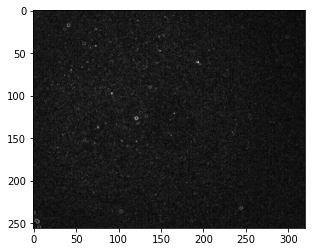

In [5]:
plt.imshow(classes["0.725"]["600"][0],cmap="gray")

In [6]:
nb_mcl = len(classes["0.725"])
nb_ra  = len(classes)

gran = Granulometry(1, 20, 2)

X = []
Ra = []
MCL = []
Granulo = []
nbPoint = []

for key_ra, ra in classes.items():
    for key_mcl, mcl in classes[key_ra].items():
        for picture in mcl:
            
            image = picture
            #image preproc
            val = filters.threshold_otsu(image)
            image_otsu = image < val
            # granulo
            Granulo.append(gran.granulometry(image_otsu))
            #labeling
            label_image = label(image_otsu, connectivity=2)
            np_point = len(np.unique(label_image))
            nbPoint.append(np_point)
            
            X.append(picture.flatten())
            Ra.append(key_ra)
            MCL.append(key_mcl)
            
data = {'X': X,
        'class': Ra,
        'MCL': MCL,
        'granulo': Granulo,
        'nbPoint': nbPoint
        }

df = pd.DataFrame(data)

print (df)

                                                     X  class  MCL  \
0    [0.00392156862745098, 0.0196078431372549, 0.02...  1.198  600   
1    [0.01568627450980392, 0.023529411764705882, 0....  1.198  600   
2    [0.0196078431372549, 0.027450980392156862, 0.0...  1.198  600   
3    [0.01568627450980392, 0.03137254901960784, 0.0...  1.198  600   
4    [0.0196078431372549, 0.027450980392156862, 0.0...  1.198  600   
..                                                 ...    ...  ...   
149  [0.011764705882352941, 0.0196078431372549, 0.0...  0.725  600   
150  [0.0196078431372549, 0.01568627450980392, 0.03...  0.725  600   
151  [0.01568627450980392, 0.023529411764705882, 0....  0.725  600   
152  [0.011764705882352941, 0.011764705882352941, 0...  0.725  600   
153  [0.00784313725490196, 0.0196078431372549, 0.03...  0.725  600   

                                       granulo  nbPoint  
0      [36964, 6910, 739, 0, 0, 0, 0, 0, 0, 0]      257  
1          [11027, 29, 0, 0, 0, 0, 0, 0, 0,

In [17]:

X2 = np.stack(df['granulo'].to_numpy())
X3 = np.stack(df['nbPoint'].to_numpy())
y = df['class'].to_numpy()

# for classification
enc = OneHotEncoder()
y = enc.fit_transform(y.reshape(-1,1)).toarray()

X2 = minMaxRescale(X2)
X3 = minMaxRescale(X3).reshape(-1,1)
X = np.append(X2,X3,axis=1)
#X = np.append(X,X3,axis=1)
pca = PCA(n_components=3)
X = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [18]:
#y_train = y_train.reshape(-1,1)
#y_test = y_test.reshape(-1,1)
#y_test = np.array(y_test)
#y_train = np.array(y_train)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(123, 3)
(123, 10)
(31, 3)
(31, 10)


# MLP

In [102]:
BATCH_SIZE = 64
NB_HIDDEN_NEURON = 20

model = Sequential() 
model.add(Input(shape=(X_train.shape[1])))
model.add(Dense(NB_HIDDEN_NEURON, kernel_initializer = 'glorot_uniform', activation = 'relu'))  
model.add(Dense(10, kernel_initializer = 'glorot_uniform', activation = 'softmax'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 20)                80        
                                                                 
 dense_19 (Dense)            (None, 10)                210       
                                                                 
Total params: 290
Trainable params: 290
Non-trainable params: 0
_________________________________________________________________


In [103]:
model.compile(
    loss = 'CategoricalCrossentropy', 
    optimizer = "adam", 
    metrics = ['accuracy']
)

In [104]:
history = model.fit(
    X_train, y_train,    
    batch_size=BATCH_SIZE, 
    epochs = 200, 
    verbose = 1, 
    validation_split = 0.2, 
)

Epoch 1/200
2/2 [==============================] - 0s 141ms/step - loss: 2.3102 - accuracy: 0.1224 - val_loss: 2.3153 - val_accuracy: 0.0800
Epoch 2/200
2/2 [==============================] - 0s 28ms/step - loss: 2.3040 - accuracy: 0.1224 - val_loss: 2.3099 - val_accuracy: 0.0800
Epoch 3/200
2/2 [==============================] - 0s 27ms/step - loss: 2.2977 - accuracy: 0.1224 - val_loss: 2.3046 - val_accuracy: 0.0800
Epoch 4/200
2/2 [==============================] - 0s 30ms/step - loss: 2.2921 - accuracy: 0.1224 - val_loss: 2.2995 - val_accuracy: 0.0800
Epoch 5/200
2/2 [==============================] - 0s 29ms/step - loss: 2.2863 - accuracy: 0.1327 - val_loss: 2.2948 - val_accuracy: 0.0800
Epoch 6/200
2/2 [==============================] - 0s 31ms/step - loss: 2.2806 - accuracy: 0.1429 - val_loss: 2.2898 - val_accuracy: 0.0800
Epoch 7/200
2/2 [==============================] - 0s 29ms/step - loss: 2.2747 - accuracy: 0.1429 - val_loss: 2.2849 - val_accuracy: 0.0800
Epoch 8/200
2/2 [==

2/2 [==============================] - 0s 25ms/step - loss: 1.7542 - accuracy: 0.3469 - val_loss: 1.7955 - val_accuracy: 0.2800
Epoch 118/200
2/2 [==============================] - 0s 27ms/step - loss: 1.7515 - accuracy: 0.3469 - val_loss: 1.7925 - val_accuracy: 0.2800
Epoch 119/200
2/2 [==============================] - 0s 27ms/step - loss: 1.7488 - accuracy: 0.3469 - val_loss: 1.7897 - val_accuracy: 0.2800
Epoch 120/200
2/2 [==============================] - 0s 27ms/step - loss: 1.7463 - accuracy: 0.3469 - val_loss: 1.7873 - val_accuracy: 0.2800
Epoch 121/200
2/2 [==============================] - 0s 28ms/step - loss: 1.7437 - accuracy: 0.3469 - val_loss: 1.7845 - val_accuracy: 0.2800
Epoch 122/200
2/2 [==============================] - 0s 27ms/step - loss: 1.7413 - accuracy: 0.3469 - val_loss: 1.7819 - val_accuracy: 0.2800
Epoch 123/200
2/2 [==============================] - 0s 26ms/step - loss: 1.7387 - accuracy: 0.3469 - val_loss: 1.7789 - val_accuracy: 0.2800
Epoch 124/200
2/2 [=

Epoch 175/200
2/2 [==============================] - 0s 28ms/step - loss: 1.6521 - accuracy: 0.3469 - val_loss: 1.6876 - val_accuracy: 0.2800
Epoch 176/200
2/2 [==============================] - 0s 28ms/step - loss: 1.6510 - accuracy: 0.3469 - val_loss: 1.6861 - val_accuracy: 0.2800
Epoch 177/200
2/2 [==============================] - 0s 28ms/step - loss: 1.6498 - accuracy: 0.3469 - val_loss: 1.6849 - val_accuracy: 0.2800
Epoch 178/200
2/2 [==============================] - 0s 28ms/step - loss: 1.6487 - accuracy: 0.3469 - val_loss: 1.6839 - val_accuracy: 0.2800
Epoch 179/200
2/2 [==============================] - 0s 27ms/step - loss: 1.6477 - accuracy: 0.3469 - val_loss: 1.6830 - val_accuracy: 0.2800
Epoch 180/200
2/2 [==============================] - 0s 26ms/step - loss: 1.6465 - accuracy: 0.3469 - val_loss: 1.6821 - val_accuracy: 0.2800
Epoch 181/200
2/2 [==============================] - 0s 29ms/step - loss: 1.6455 - accuracy: 0.3469 - val_loss: 1.6814 - val_accuracy: 0.2800
Epoch 

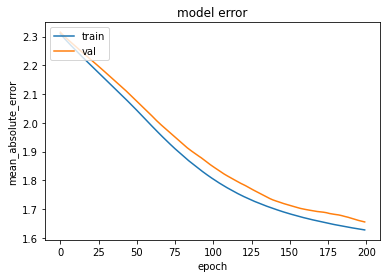

In [105]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model error')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [106]:
score = model.evaluate(X_test, y_test, verbose = 0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])
score

Test loss: 1.7645925283432007
Test accuracy: 0.16129031777381897


[1.7645925283432007, 0.16129031777381897]

In [107]:
from sklearn.metrics import confusion_matrix


In [108]:
pred = model.predict(X_test) 
confusion_matrix(np.argmax(y_test,axis=1), np.argmax(pred,axis=1))

array([[0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 5, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 2, 1],
       [0, 0, 0, 0, 2, 0, 0, 0, 4, 1]])

In [15]:
model.save('classification.h5')

# Logistic regression

In [53]:
y_tr_enc = np.argmax(y_train, axis=1)
y_ts_enc = np.argmax(y_test, axis=1)

In [54]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, multi_class="ovr").fit(X_train, y_tr_enc)

In [55]:
print(clf.score(X_train, y_tr_enc))
print(clf.score(X_test, y_ts_enc))

0.22764227642276422
0.16129032258064516


In [56]:
pred_clf = clf.predict(X_test)
confusion_matrix(np.argmax(y_test,axis=1), pred_clf)

array([[0, 3, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 3, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 4, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 4, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 5, 1]])

# Experience 2

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
granuloMM = MinMaxScaler()
labelMM = MinMaxScaler()


X2 = np.stack(df['granulo'].to_numpy())
X3 = np.stack(df['nbPoint'].to_numpy())
y = df['class'].to_numpy()

enc = LabelEncoder()
y = enc.fit_transform(y)

classes = list(enc.inverse_transform(range(10)))
print(classes)

y = y <= 4
print(np.unique(y, return_counts=True))
granuloMM.fit(X2)
X2 = granuloMM.transform(X2)

print(X2.shape)

labelMM.fit(X3.reshape(-1,1))
X3 = labelMM.transform(X3.reshape(-1,1))

X = np.append(X2,X3,axis=1)
#X = np.append(X,X3,axis=1)
pca = PCA(n_components=3)
X = pca.fit_transform(X)

pkl_filename = "pca.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(pca, file)

pkl_filename = "granuloMinMax.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(granuloMM, file)

pkl_filename = "labelMinMax.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(labelMM, file)

    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

['0.677', '0.725', '0.735', '0.810', '1.161', '1.198', '1.710', '2.176', '2.277', '2.316']
(array([False,  True]), array([76, 78]))
(154, 10)


In [24]:
X_train

array([[-1.13547399e+00,  5.12937586e-01,  1.31101973e-02,
        -1.31785180e-03],
       [ 1.39889787e+00, -3.86836622e-02,  1.12570509e-01,
        -4.06165579e-03],
       [-9.23542393e-01, -2.13042184e-01, -6.65465342e-02,
        -1.32240116e-02],
       [-9.20493218e-01, -2.07411178e-01, -5.59470741e-02,
        -1.01616037e-02],
       [ 1.69759958e+00,  5.46494068e-02, -1.19210837e-02,
        -3.33615403e-02],
       [-1.14636004e+00,  5.65459893e-01,  2.90078380e-02,
         3.12994201e-03],
       [ 1.66223303e+00,  4.29145220e-02,  3.80915519e-03,
        -9.31705737e-02],
       [-9.13651229e-01, -2.39107300e-01, -6.65715316e-02,
        -1.34835117e-02],
       [ 1.89160154e+00,  1.19825139e-01, -1.39751764e-01,
         7.25843464e-02],
       [-9.21726975e-01, -2.04467672e-01, -5.83481052e-02,
        -1.22178674e-02],
       [ 1.35033771e+00, -5.85145236e-02,  1.42826811e-01,
        -3.31829078e-02],
       [-9.09543401e-01, -2.35294200e-01, -5.30053956e-02,
      

In [11]:
BATCH_SIZE = 64
NB_HIDDEN_NEURON = 20

model = Sequential() 
model.add(Input(shape=(X_train.shape[1])))
model.add(Dense(NB_HIDDEN_NEURON, kernel_initializer = 'glorot_uniform', activation = 'relu'))  
model.add(Dense(1, kernel_initializer = 'glorot_uniform', activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                80        
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(loss = 'BinaryCrossentropy', optimizer = "adam", metrics = ['accuracy'])
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs = 200, verbose = 1, validation_split = 0.2)

Epoch 1/200
2/2 [==============================] - 1s 167ms/step - loss: 0.8258 - accuracy: 0.1224 - val_loss: 0.8081 - val_accuracy: 0.0800
Epoch 2/200
2/2 [==============================] - 0s 30ms/step - loss: 0.8164 - accuracy: 0.1224 - val_loss: 0.7993 - val_accuracy: 0.0800
Epoch 3/200
2/2 [==============================] - 0s 48ms/step - loss: 0.8072 - accuracy: 0.1224 - val_loss: 0.7906 - val_accuracy: 0.0800
Epoch 4/200
2/2 [==============================] - 0s 44ms/step - loss: 0.7985 - accuracy: 0.1224 - val_loss: 0.7820 - val_accuracy: 0.0800
Epoch 5/200
2/2 [==============================] - 0s 33ms/step - loss: 0.7900 - accuracy: 0.1429 - val_loss: 0.7735 - val_accuracy: 0.0800
Epoch 6/200
2/2 [==============================] - 0s 24ms/step - loss: 0.7813 - accuracy: 0.1531 - val_loss: 0.7651 - val_accuracy: 0.0800
Epoch 7/200
2/2 [==============================] - 0s 25ms/step - loss: 0.7731 - accuracy: 0.1837 - val_loss: 0.7568 - val_accuracy: 0.1600
Epoch 8/200
2/2 [==

2/2 [==============================] - 0s 25ms/step - loss: 0.4945 - accuracy: 0.8776 - val_loss: 0.4516 - val_accuracy: 0.9200
Epoch 60/200
2/2 [==============================] - 0s 28ms/step - loss: 0.4913 - accuracy: 0.8776 - val_loss: 0.4475 - val_accuracy: 0.9200
Epoch 61/200
2/2 [==============================] - 0s 30ms/step - loss: 0.4881 - accuracy: 0.8776 - val_loss: 0.4435 - val_accuracy: 0.9200
Epoch 62/200
2/2 [==============================] - 0s 25ms/step - loss: 0.4851 - accuracy: 0.8776 - val_loss: 0.4396 - val_accuracy: 0.9200
Epoch 63/200
2/2 [==============================] - 0s 25ms/step - loss: 0.4820 - accuracy: 0.8776 - val_loss: 0.4357 - val_accuracy: 0.9200
Epoch 64/200
2/2 [==============================] - 0s 30ms/step - loss: 0.4788 - accuracy: 0.8776 - val_loss: 0.4320 - val_accuracy: 0.9200
Epoch 65/200
2/2 [==============================] - 0s 25ms/step - loss: 0.4761 - accuracy: 0.8776 - val_loss: 0.4282 - val_accuracy: 0.9200
Epoch 66/200
2/2 [========

2/2 [==============================] - 0s 28ms/step - loss: 0.3786 - accuracy: 0.8776 - val_loss: 0.2972 - val_accuracy: 0.9200
Epoch 118/200
2/2 [==============================] - 0s 28ms/step - loss: 0.3776 - accuracy: 0.8776 - val_loss: 0.2957 - val_accuracy: 0.9200
Epoch 119/200
2/2 [==============================] - 0s 29ms/step - loss: 0.3767 - accuracy: 0.8776 - val_loss: 0.2943 - val_accuracy: 0.9200
Epoch 120/200
2/2 [==============================] - 0s 22ms/step - loss: 0.3757 - accuracy: 0.8776 - val_loss: 0.2930 - val_accuracy: 0.9200
Epoch 121/200
2/2 [==============================] - 0s 22ms/step - loss: 0.3747 - accuracy: 0.8776 - val_loss: 0.2917 - val_accuracy: 0.9200
Epoch 122/200
2/2 [==============================] - 0s 37ms/step - loss: 0.3738 - accuracy: 0.8776 - val_loss: 0.2904 - val_accuracy: 0.9200
Epoch 123/200
2/2 [==============================] - 0s 24ms/step - loss: 0.3728 - accuracy: 0.8776 - val_loss: 0.2892 - val_accuracy: 0.9200
Epoch 124/200
2/2 [=

Epoch 175/200
2/2 [==============================] - 0s 24ms/step - loss: 0.3436 - accuracy: 0.8776 - val_loss: 0.2495 - val_accuracy: 0.9200
Epoch 176/200
2/2 [==============================] - 0s 23ms/step - loss: 0.3433 - accuracy: 0.8776 - val_loss: 0.2491 - val_accuracy: 0.9200
Epoch 177/200
2/2 [==============================] - 0s 28ms/step - loss: 0.3429 - accuracy: 0.8776 - val_loss: 0.2487 - val_accuracy: 0.9200
Epoch 178/200
2/2 [==============================] - 0s 24ms/step - loss: 0.3426 - accuracy: 0.8776 - val_loss: 0.2483 - val_accuracy: 0.9200
Epoch 179/200
2/2 [==============================] - 0s 22ms/step - loss: 0.3423 - accuracy: 0.8776 - val_loss: 0.2479 - val_accuracy: 0.9200
Epoch 180/200
2/2 [==============================] - 0s 22ms/step - loss: 0.3420 - accuracy: 0.8776 - val_loss: 0.2475 - val_accuracy: 0.9200
Epoch 181/200
2/2 [==============================] - 0s 22ms/step - loss: 0.3417 - accuracy: 0.8776 - val_loss: 0.2471 - val_accuracy: 0.9200
Epoch 

In [13]:
score = model.evaluate(X_test, y_test, verbose = 0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])
score

Test loss: 0.38344523310661316
Test accuracy: 0.8387096524238586


[0.38344523310661316, 0.8387096524238586]

In [14]:
pred = model.predict(X_test) 
print(pred)
confusion_matrix(np.argmax(y_test.reshape(-1,1),axis=1), np.argmax(pred,axis=1))

[[0.03687087]
 [0.05054203]
 [0.77145374]
 [0.7754324 ]
 [0.81377435]
 [0.7740313 ]
 [0.81324124]
 [0.06004101]
 [0.8099017 ]
 [0.76886964]
 [0.812124  ]
 [0.1000008 ]
 [0.80993325]
 [0.81162524]
 [0.06726363]
 [0.81125   ]
 [0.8139735 ]
 [0.04312247]
 [0.04386342]
 [0.05779734]
 [0.81258273]
 [0.8114884 ]
 [0.04560906]
 [0.77340645]
 [0.08163515]
 [0.81154597]
 [0.77444655]
 [0.81307584]
 [0.8127459 ]
 [0.04042572]
 [0.8118153 ]]


NameError: name 'confusion_matrix' is not defined

# LDA

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


In [33]:
lda = LDA(n_components=1)
X_train_moved = lda.fit_transform(X_train, y_train)

In [35]:
NB_FOLD = 10
IMAGE_BY_FOLD = len(X_train) / NB_FOLD
folds = np.arange(NB_FOLD)
folds = np.repeat(folds, IMAGE_BY_FOLD)

# just triming the rest of the division above
X_train_trim = X_train[:len(folds)]
y_train_trim = y_train[:len(folds)]

accuracy = []

for i in range(NB_FOLD):
    
    train_index = folds!=i
    test_index = folds==i
    # Preparing the datasets
    Fold_train_x = X_train_trim[train_index]
    Fold_test_x  = X_train_trim[test_index]
    Fold_train_y = y_train_trim[train_index]
    Fold_test_y  = y_train_trim[test_index]
    
    print("FOLD N:", i)
    lda = LDA(n_components=1)
    lda.fit_transform(Fold_train_x, Fold_train_y)
    accuracy.append(lda.score(Fold_test_x,Fold_test_y))
   

FOLD N: 0
FOLD N: 1
FOLD N: 2
FOLD N: 3
FOLD N: 4
FOLD N: 5
FOLD N: 6
FOLD N: 7
FOLD N: 8
FOLD N: 9


{'whiskers': [<matplotlib.lines.Line2D at 0x7f73926a5090>,
 'caps': [<matplotlib.lines.Line2D at 0x7f73926a5950>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7392694f50>],
 'medians': [<matplotlib.lines.Line2D at 0x7f73926b9050>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f73926b9390>],
 'means': []}

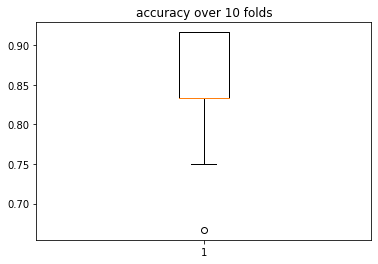

In [36]:
plt.title("accuracy over 10 folds")
plt.boxplot(accuracy)

In [37]:
print(lda.score(X_test,y_test))
lda.predict(X_test)

0.967741935483871


array([ True, False,  True,  True,  True, False, False, False, False,
        True, False, False, False,  True, False,  True,  True, False,
       False, False,  True,  True, False,  True, False,  True,  True,
        True, False,  True,  True])

In [38]:
import pickle

In [39]:
pkl_filename = "classification_lda.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(lda, file)